# Test Deconvolution with Different basis sets.

This notebook demonstrates the functionality of response_fitter. 

First, a signal composed of a mixture of different signals, created using a standard BOLD response HRF and a different IRF shape and gaussian noise is added. Event-related responses are then fit from this signal, demonstrating how one would use FIRDeconvolution for data analysis on recorded signals. 

We propose that first attempt at tinkering with this code would be to change the parameters in the second code cell, which specify the parameters of the simulated signal and the deconvolution. One can then run the whole notebook anew, with or without re-creating the signals. 


### Imports

In [57]:
from __future__ import division
import numpy as np
import scipy as sp
import scipy.signal as signal

import matplotlib

import matplotlib.pyplot as pl
%matplotlib inline 

import seaborn as sn
sn.set(style="ticks")

### Parameters specifying simulated data and analysis

In [58]:
# signal parameters
signal_sample_frequency = 4
event_1_gain, event_2_gain = 1, 1# 2.3, 0.85
noise_gain = 1.5

# deconvolution parameters
deconv_sample_frequency = 4
deconvolution_interval = [-5, 25]

# how many time points to plot in figures
plot_time = 1200

# create some exponentially distributed random ISI events (Dale, 1999) of which we will create and deconvolve responses. 
period_durs = np.random.gamma(4.0,1.5,size = 1000)
events = period_durs.cumsum()
events_1, events_2 = events[0::2], events[1::2]

# durations_1, durations_2 = np.random.gamma(2.9,0.75,size = events_1.shape[0]), np.random.gamma(2.9,0.75,size = events_2.shape[0])
durations_1, durations_2 = np.ones(events_1.shape[0])/deconv_sample_frequency, np.ones(events_2.shape[0])/deconv_sample_frequency

gains_1, gains_2 = 1, 1 # 0.4, 2.4
# these events are scaled with their own underlying covariate. 
# for instance, you could have a model-based variable that scales the signal on a per-trial basis. 
events_gains_1 = np.ones(len(events_1)) # np.random.randn(len(events_1))*gains_1
events_gains_2 = np.ones(len(events_2)) # np.random.randn(len(events_2))*gains_2


# figure parameters
figwidth, figheight = 14, 10

deconvolution_interval_size = np.int(np.round((deconvolution_interval[1] - deconvolution_interval[0])
                                              * deconv_sample_frequency))
time_points = np.linspace(deconvolution_interval[0],deconvolution_interval[1],deconvolution_interval_size)

time_points_hrf = time_points[time_points>0]


### create an IRF which we'd like to deconvolve

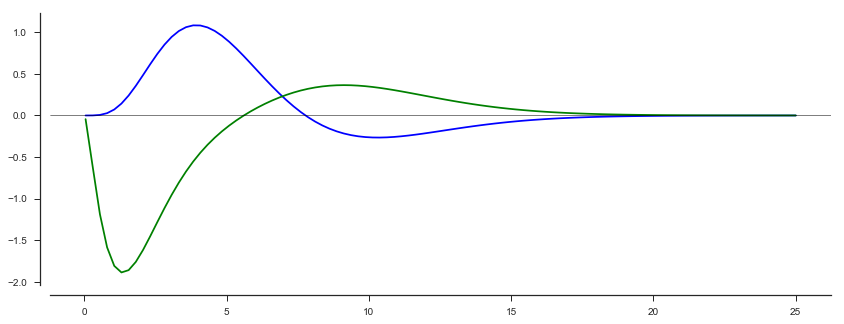

In [59]:
# We create an IRF, using a standard BOLD response and a changed version.

def double_gamma_with_d(x, a1 = 6, a2 = 12, b1 = 0.9, b2 = 0.9, c = 0.35,d1=5.4,d2=10.8):
    return np.array([(t/(d1))**a1 * np.exp(-(t-d1)/b1) - c*(t/(d2))**a2 * np.exp(-(t-d2)/b2) for t in x])

hrf_1 = double_gamma_with_d(time_points_hrf, a1 = 4.5, a2 = 10, d1 = 5.0, d2 = 10.0)
hrf_2 = -double_gamma_with_d(time_points_hrf, a1 = 1.5, a2 = 10, d1 = 3.0, d2 = 10.0)

f = pl.figure(figsize = (figwidth, figheight/2))
pl.plot(time_points_hrf, hrf_1, 'b')
pl.plot(time_points_hrf, hrf_2, 'g')
pl.axhline(0, lw=0.5, color = 'k')
sn.despine(offset=10)

# Run two simulations

1. deconvolve two types of events, each with different gains
2. deconvolve two types of events, of which the per-event gain is defined by a baseline, as in 1, and a covariate.

## Run first simulation

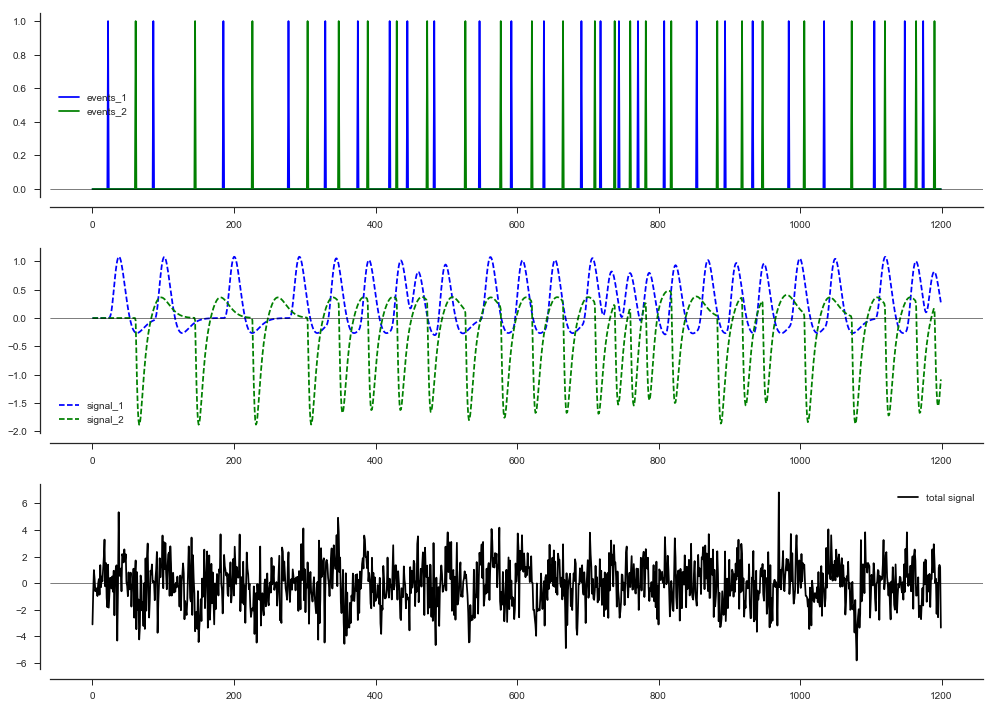

In [60]:
# Using this IRF we're going to create two signals
# signal gains are determined by random covariate and a standard gain
# we mix them all together with some noise, injected on the signal, not the events.

times = np.arange(0,events.max()+45.0,1.0/signal_sample_frequency)

event_1_in_times = np.array([((times>te) * (times<te+d)) * event_1_gain for te, d in zip(events_1, durations_1)]).sum(axis = 0)
event_2_in_times = np.array([((times>te) * (times<te+d)) * event_2_gain for te, d in zip(events_2, durations_2)]).sum(axis = 0)

signal_1 = signal.fftconvolve(event_1_in_times, hrf_1, 'full')[:times.shape[0]]
signal_2 = signal.fftconvolve(event_2_in_times, hrf_2, 'full')[:times.shape[0]]

# combine the two signals with one another, z-score and add noise
input_data = signal_1 + signal_2
# input_data = (input_data - np.mean(input_data)) / input_data.std()
input_data += np.random.randn(input_data.shape[0]) * noise_gain

f = pl.figure(figsize = (figwidth, figheight))
s = f.add_subplot(311)
pl.plot(np.arange(plot_time), event_1_in_times[:plot_time], 'b-')
pl.plot(np.arange(plot_time), event_2_in_times[:plot_time], 'g-')
pl.legend(['events_1', 'events_2',])
sn.despine(offset=10)

pl.axhline(0, lw=0.5, color = 'k')
s = f.add_subplot(312)

pl.plot(np.arange(plot_time), signal_1[:plot_time], 'b--')
pl.plot(np.arange(plot_time), signal_2[:plot_time], 'g--')
pl.legend(['signal_1', 'signal_2'])
sn.despine(offset=10)

pl.axhline(0, lw=0.5, color = 'k')
s = f.add_subplot(313)

pl.plot(np.arange(plot_time), input_data[:plot_time], 'k-')
pl.legend(['total signal'])
pl.axhline(0, lw=0.5, color = 'k')

sn.despine(offset=10)
pl.tight_layout()



## Run first analysis

We will analyze the simulated data twice. First, without taking into account the durations of the simulated events, and second, while adding the durations of the events in there. Notice the difference in explained variance between the two.

### Simple examples for different basis sets

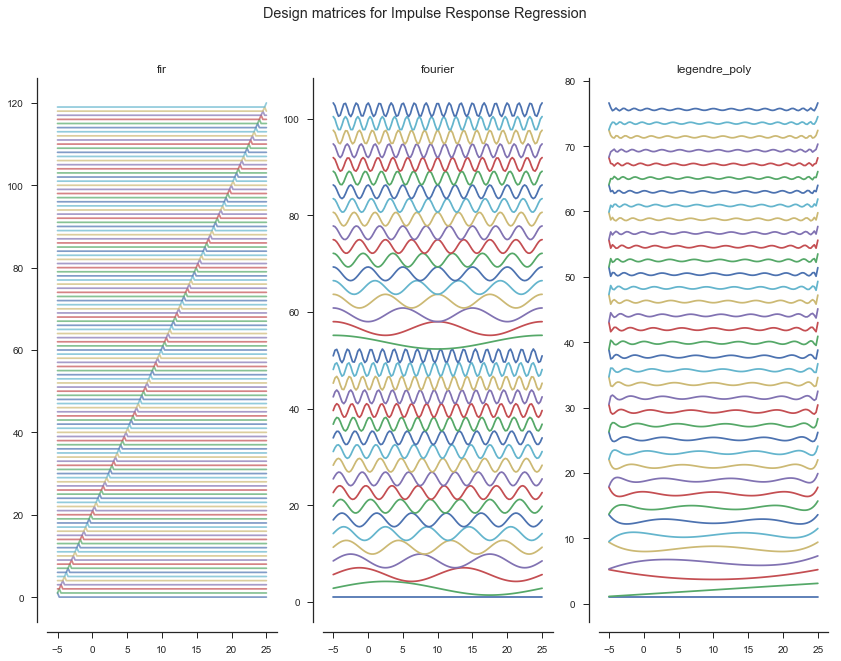

In [61]:
f = pl.figure(figsize = (figwidth, figheight))
f.suptitle('Design matrices for Impulse Response Regression')

# FIR basis set
basis_set = 'fir'
nr_regressors_per_event_type_fir = len(time_points)
L_fir = np.eye(len(time_points))
s = f.add_subplot(131)
for i, l in enumerate(L_fir):
    pl.plot(time_points, l+i, alpha=0.7)
s.set_title(basis_set)
sn.despine(offset=10)

# fourier basis set example
basis_set = 'fourier'
nr_regressors_per_event_type_fourier = 36
nr_regressors_per_event_type = nr_regressors_per_event_type_fourier
if (nr_regressors_per_event_type_fourier %2 ) == 0:
    nr_regressors_per_event_type_fourier += 1
L_fourier = np.zeros((nr_regressors_per_event_type_fourier, deconvolution_interval_size))
# Fourier basis set needs intercept
L_fourier[0,:] = 1
for r in range(int(nr_regressors_per_event_type_fourier/2)):
    x = np.linspace(0, 2.0*np.pi*(r+1), len(time_points))
#     sin_regressor 
    L_fourier[1+r,:] = np.sqrt(2) * np.sin(x)
#     cos_regressor 
    L_fourier[1+r+int(nr_regressors_per_event_type_fourier/2),:] = np.sqrt(2) * np.cos(x)
    
s = f.add_subplot(132)
for i, l in enumerate(L_fourier):
    pl.plot(time_points, l+2*i*np.sqrt(2))
s.set_title(basis_set)
sn.despine(offset=10)

# polynomial basis set example
basis_set = 'legendre_poly'
nr_regressors_per_event_type_leg = 36
nr_regressors_per_event_type = nr_regressors_per_event_type_leg
if (nr_regressors_per_event_type_leg %2 ) == 0:
    nr_regressors_per_event_type_leg += 1
L_legendre = np.zeros((nr_regressors_per_event_type_leg, deconvolution_interval_size))
x = np.linspace(-1, 1, len(time_points), endpoint=True)
L_legendre = np.polynomial.legendre.legval(x=x, c=np.eye(nr_regressors_per_event_type_leg))
    
s = f.add_subplot(133)
for i, l in enumerate(L_legendre):
    pl.plot(time_points, l+i*2.1)
s.set_title(basis_set)
sn.despine(offset=10)

## Background

The multiple linear regression goes as follows, see Dale et al, 1999. 

$$ \hat{p}_{ML} = (L^{T} X^{T} C_{n}^{-1} X L)^{-1} L^{T} X^{T} C^{-1}_{n} y $$
$$ \hat{h} _{BML}= L \hat{p} _{ML} $$

$X$ is a design matrix, constructed using the event occurrence times and their durations. Its construction starts out with just a vector of all timepoints in the data, with values of 1 indexing when things happened, which is then convolved with all the rows in $L$, the subspace projection matrix that relates event occurrences to timepoints surrounding the events (see the figures above). You see that for the FIR model, this $L$ matrix is just the $I$ matrix, whereas for fourier and legendre basis sets $L$ describes the basis function set for this specific basis. 

$C$, the noise covariance matrix, is assumed to be $I$ at first (OLS solution), and can be estimated based on the residuals (not implemented here).

## FIR basis example

In [62]:
L_format = L_fir
nr_regressors_per_event_type = nr_regressors_per_event_type_fir
n_event_types = 2
# construct designmatrix
X = np.zeros(((n_event_types*nr_regressors_per_event_type_fir),input_data.shape[0]))
L = np.zeros(((nr_regressors_per_event_type_fir), 
                  len(time_points)*n_event_types))

for i in range(n_event_types):
    ev, durs = [[events_1, durations_1],[events_2, durations_2]][i]
    event_timepoints = np.zeros((input_data.shape[0],len(time_points)))
    mean_dur = durs.mean()
    for e,d in zip(ev, durs):
        et, dt = int((e+deconvolution_interval[0])*deconv_sample_frequency), int(d*deconv_sample_frequency)
        event_timepoints[et:et+dt,:] = 1.0/(deconv_sample_frequency*mean_dur)
        
    this_X = np.dot(event_timepoints, np.eye(len(time_points))).T
    for r in range(nr_regressors_per_event_type_fir):
        X[i*nr_regressors_per_event_type_fir + r] = \
            sp.signal.fftconvolve(this_X[0,:], L_format[r])[:input_data.shape[0]]

C = C_inv = np.eye(L.shape[0])
X1  = np.r_[np.ones((1,input_data.shape[0])), X]
betas, residuals, rank, s = np.linalg.lstsq(X1.T, input_data)

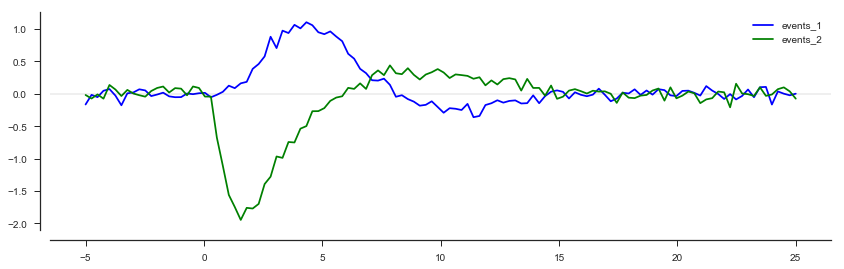

In [63]:
f = pl.figure(figsize = (figwidth, 4))
s = f.add_subplot(111)
pl.plot(time_points, np.dot(betas[1:1+nr_regressors_per_event_type_fir], L_format), 'b')
pl.plot(time_points, np.dot(betas[1+(nr_regressors_per_event_type_fir*1):1+(nr_regressors_per_event_type_fir*2)], L_format), 'g')

# pl.plot(time_points_hrf, hrf_1, 'b--')
# pl.plot(time_points_hrf, hrf_2, 'g--')

pl.axhline(0, lw=0.25, alpha=0.5, color = 'k')
pl.legend(['events_1', 'events_2',])
sn.despine(offset=10)

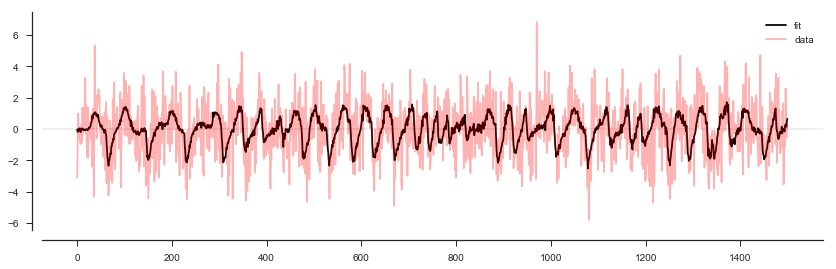

In [64]:
f = pl.figure(figsize = (figwidth, 4))
s = f.add_subplot(111)
pl.plot(np.dot(betas, X1)[:1500], 'k')
pl.plot(input_data[:1500], 'r', alpha = 0.3)
pl.axhline(0, lw=0.25, alpha=0.5, color = 'k')
pl.legend(['fit', 'data',])
sn.despine(offset=10)

## Fourier basis example

In [65]:
L_format = L_fourier
n_event_types = 2
# construct designmatrix
X = np.zeros(((n_event_types*nr_regressors_per_event_type_fourier),input_data.shape[0]))
L = np.zeros(((nr_regressors_per_event_type_fourier), 
                  len(time_points)*n_event_types))

for i in range(n_event_types):
    ev, durs = [[events_1, durations_1],[events_2, durations_2]][i]
    event_timepoints = np.zeros((input_data.shape[0],len(time_points)))
    mean_dur = durs.mean()
    for e,d in zip(ev, durs):
        et, dt = int((e+deconvolution_interval[0])*deconv_sample_frequency), int(d*deconv_sample_frequency)
        event_timepoints[et:et+dt,:] = 1.0/(deconv_sample_frequency*mean_dur)
        
    this_X = np.dot(event_timepoints, np.eye(len(time_points))).T
    for r in range(nr_regressors_per_event_type_fourier):
        X[i*nr_regressors_per_event_type_fourier + r] = \
            sp.signal.fftconvolve(this_X[0,:], L_format[r])[:input_data.shape[0]]

C = C_inv = np.eye(L.shape[0])
# add global intercept
X1  = np.r_[np.ones((1,input_data.shape[0])), X]
betas, residuals, rank, s = np.linalg.lstsq(X1.T, input_data)

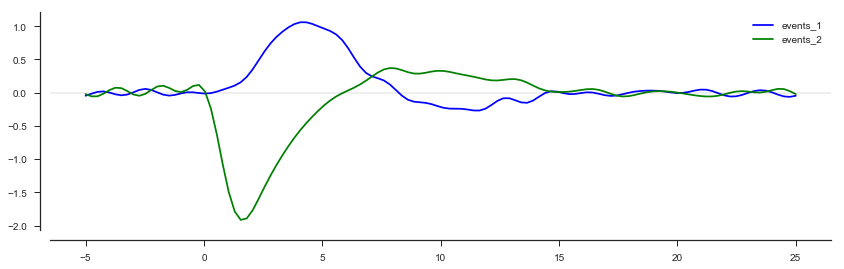

In [66]:
f = pl.figure(figsize = (figwidth, 4))
s = f.add_subplot(111)
pl.plot(time_points, np.dot(betas[1:1+nr_regressors_per_event_type_fourier], L_format), 'b')
pl.plot(time_points, np.dot(betas[1+(nr_regressors_per_event_type_fourier*1):1+(nr_regressors_per_event_type_fourier*2)], L_format), 'g')

# pl.plot(time_points_hrf, hrf_1, 'b--')
# pl.plot(time_points_hrf, hrf_2, 'g--')

pl.axhline(0, lw=0.25, alpha=0.5, color = 'k')
pl.legend(['events_1', 'events_2',])
sn.despine(offset=10)

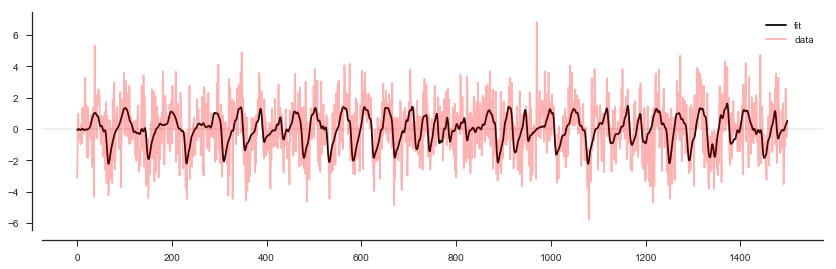

In [67]:
f = pl.figure(figsize = (figwidth, 4))
s = f.add_subplot(111)
pl.plot(np.dot(betas, X1)[:1500], 'k')
pl.plot(input_data[:1500], 'r', alpha = 0.3)
pl.axhline(0, lw=0.25, alpha=0.5, color = 'k')
pl.legend(['fit', 'data',])
sn.despine(offset=10)

## Legendre Polynomial basis example

In [68]:
L_format = L_legendre

n_event_types = 2
# construct designmatrix
X = np.zeros(((n_event_types*nr_regressors_per_event_type_leg),input_data.shape[0]))
L = np.zeros(((nr_regressors_per_event_type_leg), 
                  len(time_points)*n_event_types))

for i in range(n_event_types):
    ev, durs = [[events_1, durations_1],[events_2, durations_2]][i]
    event_timepoints = np.zeros((input_data.shape[0],len(time_points)))
    mean_dur = durs.mean()
    for e,d in zip(ev, durs):
        et, dt = int((e+deconvolution_interval[0])*deconv_sample_frequency), int(d*deconv_sample_frequency)
        event_timepoints[et:et+dt,:] = 1.0/(deconv_sample_frequency*mean_dur)
        
    this_X = np.dot(event_timepoints, np.eye(len(time_points))).T
    for r in range(nr_regressors_per_event_type_leg):
        X[i*nr_regressors_per_event_type_leg + r] = \
            sp.signal.fftconvolve(this_X[0,:], L_format[r])[:input_data.shape[0]]

C = C_inv = np.eye(L.shape[0])
X1  = np.r_[np.ones((1,input_data.shape[0])), X]
betas, residuals, rank, s = np.linalg.lstsq(X1.T, input_data)

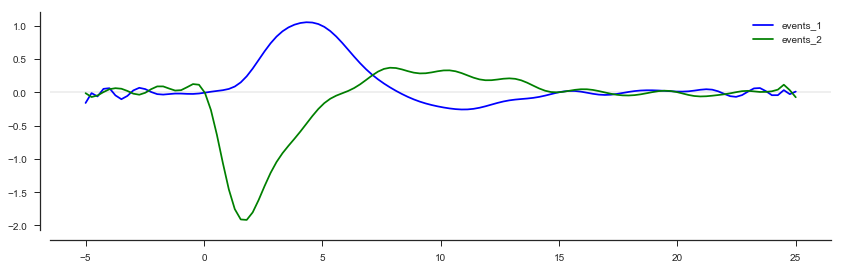

In [69]:
f = pl.figure(figsize = (figwidth, 4))
s = f.add_subplot(111)
pl.plot(time_points, np.dot(betas[1:1+nr_regressors_per_event_type_leg], L_format), 'b')
pl.plot(time_points, np.dot(betas[1+(nr_regressors_per_event_type_leg*1):1+(nr_regressors_per_event_type_leg*2)], L_format), 'g') 

# pl.plot(time_points_hrf, hrf_1, 'b--')
# pl.plot(time_points_hrf, hrf_2, 'g--')

pl.axhline(0, lw=0.25, alpha=0.5, color = 'k')
pl.legend(['events_1', 'events_2',])
sn.despine(offset=10)

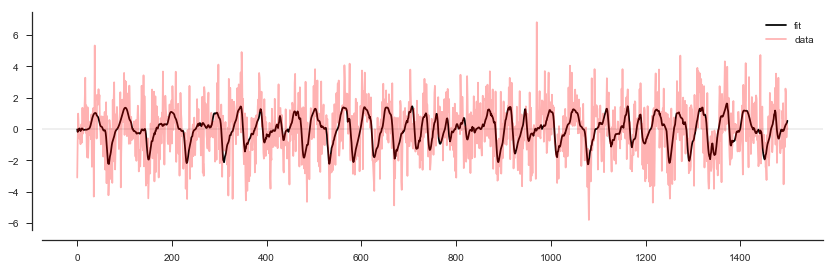

In [70]:
f = pl.figure(figsize = (figwidth, 4))
s = f.add_subplot(111)
pl.plot(np.dot(betas, X1)[:1500], 'k')
pl.plot(input_data[:1500], 'r', alpha = 0.3)
pl.axhline(0, lw=0.25, alpha=0.5, color = 'k')
pl.legend(['fit', 'data',])
sn.despine(offset=10)